In [1]:
import ast
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import math
from scipy.optimize import linear_sum_assignment

In [2]:
"""Data loading and preprocessing for knot datasets. Run only once to create the dataset file."""

def fix_mathematica_notation(line: str) -> str:
    # Fix *^ to Python's e notation
    return re.sub(r'\*\^\s*([-+]?\d+)', r'e\1', line)

def parse_line(line: str):
    # Fix notation
    line = fix_mathematica_notation(line)
    # Replace `{}` with `()`
    line_py = line.replace('{', '(').replace('}', ')')
    # Parse safely with literal_eval
    data = ast.literal_eval(line_py)
    _, input_list, target_list, _ = data
    X_in = torch.tensor(input_list, dtype=torch.float32)
    X_tar = torch.tensor(target_list, dtype=torch.float32)
    return X_in, X_tar


input_file = "nameJ2zerosJ3zerosvol.txt"   # <-- your original txt file
output_file = "knots_dataset.pt"

dataset = []
with open(input_file) as f:
    for i, line in enumerate(f):
        line_fixed = fix_mathematica_notation(line)
        X_in, X_tar = parse_line(line_fixed)
        dataset.append((X_in, X_tar))
        if i < 3:  # show some confirmation
            print(f"Example {i}: X_in shape {X_in.shape}, X_tar shape {X_tar.shape}")

torch.save(dataset, output_file)
print(f"\n Saved {len(dataset)} pairs to {output_file}")

Example 0: X_in shape torch.Size([4, 2]), X_tar shape torch.Size([12, 2])
Example 1: X_in shape torch.Size([5, 2]), X_tar shape torch.Size([15, 2])
Example 2: X_in shape torch.Size([6, 2]), X_tar shape torch.Size([18, 2])


KeyboardInterrupt: 

In [3]:
class KnotsDataset(Dataset):
    def __init__(self, pt_path):
        self.data = torch.load(pt_path)
        # adapt depending on your saved format
        # For example, assume self.data is a list of (X_in, X_tar)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # returns (X_in, X_tar)

dataset = KnotsDataset('knots_dataset.pt')

In [4]:
def knots_collate_fn(batch):
    """
    batch: list of (X_in, X_tar)
    - X_in: [N_in, 2]
    - X_tar: [N_tar, 2]  # no confidence yet!

    Returns:
      X_in_padded: (B, max_N_in, 2)
      mask_in: (B, max_N_in)
      X_tar_padded_with_conf: (B, max_N_tar, 3)
    """
    X_in_list, X_tar_list = zip(*batch)

    # Input padding + mask
    X_in_padded = pad_sequence(X_in_list, batch_first=True, padding_value=0.0)
    mask_in = torch.zeros(X_in_padded.shape[:2], dtype=torch.bool)
    for i, x in enumerate(X_in_list):
        mask_in[i, :x.size(0)] = True

    # Target padding + confidence
    X_tar_padded = pad_sequence(X_tar_list, batch_first=True, padding_value=0.0)

    B, max_N_tar, _ = X_tar_padded.shape

    # Add confidence dimension:
    X_tar_with_conf = torch.zeros(B, max_N_tar, 3)
    X_tar_with_conf[:, :, :2] = X_tar_padded

    for i, x in enumerate(X_tar_list):
        L = x.size(0)
        X_tar_with_conf[i, :L, 2] = 1.0  # confidence = 1 for real points

    return X_in_padded, mask_in, X_tar_with_conf


In [5]:
batch_size = 32
num_workers = 2

# Create indices for splitting
indices = list(range(len(dataset)))
train_indices, valtest_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(valtest_indices, test_size=0.5, random_state=42)

# Use Subset to create datasets for splits
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Make DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, collate_fn=knots_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=num_workers, collate_fn=knots_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, collate_fn=knots_collate_fn)

In [6]:
batch_X, batch_mask, _ = next(iter(train_loader))
print(batch_X.shape)     # (B, N_max, D)
print(batch_mask.shape)  # (B, N_max)
print(batch_mask.sum(dim=1))  # number of real points per sample

torch.Size([32, 16, 2])
torch.Size([32, 16])
tensor([12, 15, 13, 11, 15, 13, 15, 12, 15, 15, 13, 14, 13, 13, 15, 15, 13, 15,
        13, 13, 13, 13, 12,  9, 15, 13, 16, 15, 13, 15, 13, 14])


In [7]:
num_knots = len(train_loader.dataset)
print("Number of knots:", num_knots)

for x_tensor, x_mask, y_tensor in train_loader:
    print("x_tensor shape:", x_tensor.shape)  # (batch_size, max_len, 2)
    print("y_tensor shape:", y_tensor.shape)  # (batch_size, max_len, 3)
    break

Number of knots: 141836
x_tensor shape: torch.Size([32, 15, 2])
y_tensor shape: torch.Size([32, 55, 3])


In [8]:
class ChamferLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_reg=.1, alpha=10.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_reg = lambda_reg
        self.alpha = alpha

    def forward(self, pred_tensor, y_tensor):
        pred_coords = pred_tensor[..., :2]                  # (B, M, 2)
        pred_scores = torch.sigmoid(pred_tensor[..., 2:])   # (B, M, 1)

        true_coords = y_tensor[..., :2]
        true_scores = y_tensor[..., 2:]

        chamfer = self._chamfer_loss(pred_coords, true_coords, true_scores)
        conf_targets = self._confidence_targets(pred_coords, true_coords, true_scores)
        conf_loss = F.binary_cross_entropy(pred_scores, conf_targets)

        return self.lambda_coord * chamfer + self.lambda_conf * conf_loss + self.lambda_reg * (pred_scores ** 2).mean()

    def _chamfer_loss(self, pred_coords, true_coords, true_scores):
        """
        Weighted chamfer loss ignoring padded targets.
        """
        B, M, _ = pred_coords.shape
        N = true_coords.shape[1]
        loss = 0.0

        for b in range(B):
            tgt_mask = true_scores[b].squeeze(-1) > 0  # (N,)
            tgt_valid = true_coords[b][tgt_mask]       # (N_valid, 2)
            prd = pred_coords[b]                       # (M, 2)

            if tgt_valid.shape[0] == 0:
                continue

            dists = torch.cdist(prd, tgt_valid)  # (M, N_valid)
            min_pred_to_tgt = dists.min(dim=1)[0].mean()
            min_tgt_to_pred = dists.min(dim=0)[0].mean()
            loss += min_pred_to_tgt + min_tgt_to_pred

        return loss / B

    def _confidence_targets(self, pred_coords, true_coords, true_scores):
        """
        Compute soft targets for predicted confidences using
        soft-min similarity with ground truth coordinates.
        """
        B, M, _ = pred_coords.shape
        N = true_coords.shape[1]

        dists = torch.cdist(pred_coords, true_coords)  # (B, M, N)

        pad_mask = (true_scores.squeeze(-1) == 0).unsqueeze(1)  # (B, 1, N)
        dists = dists.masked_fill(pad_mask, float('inf'))

        soft_scores = torch.exp(-self.alpha * dists ** 2)  # (B, M, N)
        targets = soft_scores.max(dim=2, keepdim=True)[0]  # (B, M, 1)
        return targets


In [9]:
"""Very slow, not differentiable"""

class HungarianLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_fp=1.0, threshold=0.01):
        """
        lambda_coord: weight for coordinate loss
        lambda_conf: weight for matched confidence loss
        lambda_fp: weight for unmatched prediction (false positive) penalty
        threshold: confidence threshold for considering a predicted point valid
        """
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_fp = lambda_fp
        self.threshold = threshold

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor:  (B, M, 3) – predicted (x, y, conf), conf ∈ [0, 1] (already sigmoid-ed)
        target_tensor: (B, M, 3) – target (x, y, conf), where conf = 0 indicates padding
        """
        device = pred_tensor.device
        batch_size, _, _ = pred_tensor.shape
        total_loss = 0.0
        valid_batches = 0

        for b in range(batch_size):
            pred = pred_tensor[b]      # (M, 3)
            target = target_tensor[b]  # (M, 3)

            # Filter predicted points with low confidence
            pred_valid_mask = pred[:, 2] > self.threshold
            pred_valid = pred[pred_valid_mask]

            # Filter target (non-padding) points
            target_valid_mask = target[:, 2] > 0.5
            target_valid = target[target_valid_mask]

            if pred_valid.shape[0] == 0 and target_valid.shape[0] == 0:
                continue  # skip completely empty samples

            if pred_valid.shape[0] == 0 or target_valid.shape[0] == 0:
                # If only one side is empty, treat all preds as false positives or all targets as missed
                unmatched_preds = pred[pred_valid_mask]
                if unmatched_preds.shape[0] > 0:
                    fp_loss = F.binary_cross_entropy(
                        unmatched_preds[:, 2].clamp(0.0, 1.0),
                        torch.zeros_like(unmatched_preds[:, 2])
                    )
                    total_loss += self.lambda_fp * fp_loss
                    valid_batches += 1
                continue

            # Compute cost matrix (squared L2 distance)
            cost = torch.cdist(pred_valid[:, :2], target_valid[:, :2], p=2).pow(2)
            row_ind, col_ind = linear_sum_assignment(cost.detach().cpu().numpy())

            matched_preds = pred_valid[row_ind]         # (K, 3)
            matched_targets = target_valid[col_ind]     # (K, 3)

            # Coordinate loss
            coord_loss = F.mse_loss(matched_preds[:, :2], matched_targets[:, :2])

            # Confidence loss for matched points
            matched_pred_conf = matched_preds[:, 2].clamp(0.0, 1.0)
            matched_target_conf = matched_targets[:, 2]
            conf_loss = F.binary_cross_entropy(matched_pred_conf, matched_target_conf)

            # Confidence loss for unmatched predictions (false positives)
            all_indices = torch.arange(pred_valid.shape[0], device=device)
            unmatched_mask = ~torch.isin(all_indices, torch.tensor(row_ind, device=device))
            if unmatched_mask.any():
                unmatched_preds = pred_valid[unmatched_mask]
                fp_conf_loss = F.binary_cross_entropy(
                    unmatched_preds[:, 2].clamp(0.0, 1.0),
                    torch.zeros_like(unmatched_preds[:, 2])
                )
            else:
                fp_conf_loss = torch.tensor(0.0, device=device)

            total_loss += (
                self.lambda_coord * coord_loss +
                self.lambda_conf * conf_loss +
                self.lambda_fp * fp_conf_loss
            )
            valid_batches += 1

        if valid_batches == 0:
            return torch.tensor(0.0, device=pred_tensor.device, requires_grad=True)
        return total_loss / valid_batches

In [10]:
def sinkhorn(log_alpha, mask_pred, mask_target, n_iters=20, eps=1e-6):
    """
    log_alpha: (B, M, N)
    mask_pred: (B, M)
    mask_target: (B, N)
    Returns soft assignment (B, M, N) respecting masks
    """
    B, M, N = log_alpha.shape

    # Masked log_alpha: set invalid entries to -inf (for logsumexp)
    mask = mask_pred.unsqueeze(2) * mask_target.unsqueeze(1)  # (B, M, N)
    log_alpha = log_alpha.masked_fill(mask == 0, float('-inf'))

    # Stabilize
    log_alpha = log_alpha - torch.nan_to_num(torch.amax(log_alpha, dim=[1, 2], keepdim=True), nan=0.0)

    for _ in range(n_iters):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, dim=2, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, dim=1, keepdim=True)

    return log_alpha.exp() * mask  # ensure zeros outside valid area


class SinkHornLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_fp=1.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_fp = lambda_fp

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor: (B, M, 3) – (x, y, conf)
        target_tensor: (B, N, 3) – (x, y, conf), conf=0 means padding
        """
        B, M, _ = pred_tensor.shape
        N = target_tensor.shape[1]

        pred_xy = pred_tensor[:, :, :2]
        pred_conf = pred_tensor[:, :, 2]

        target_xy = target_tensor[:, :, :2]
        target_conf = target_tensor[:, :, 2]

        # Masks: 1 for valid entries, 0 for padded
        mask_pred = (pred_conf > 0.01).float()
        mask_target = (target_conf > 0.01).float()

        # Pairwise squared distances
        diff = pred_xy.unsqueeze(2) - target_xy.unsqueeze(1)
        dist_sq = (diff ** 2).sum(dim=-1)  # (B, M, N)

        log_alpha = -dist_sq

        # Sinkhorn soft match with masks
        P = sinkhorn(log_alpha, mask_pred, mask_target)  # (B, M, N)

        # Coord loss: weighted squared distance
        coord_loss = (P * dist_sq).sum(dim=[1, 2])  # (B,)

        # Confidence target: weighted sum of matched target confs
        conf_target = (P * target_conf.unsqueeze(1)).sum(dim=2)  # (B, M)
        conf_loss = F.binary_cross_entropy(pred_conf.clamp(0, 1), conf_target, reduction='none')
        conf_loss = (conf_loss * mask_pred).sum(dim=1)

        # Overprediction penalty: unmatched predictions → conf ≈ 0
        matched_mass = P.sum(dim=2)  # (B, M)
        fp_loss = (F.binary_cross_entropy(pred_conf.clamp(0, 1), torch.zeros_like(pred_conf), reduction='none') *
                   (1.0 - matched_mass) * mask_pred).sum(dim=1)

        total_loss = (
            self.lambda_coord * coord_loss +
            self.lambda_conf * conf_loss +
            self.lambda_fp * fp_loss
        )

        return total_loss.mean()

In [11]:
class DeepSets(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, num_outputs=49):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.pooling = lambda x, mask: torch.sum(x * mask.unsqueeze(-1), dim=1)  # (B, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_outputs * 3)  # (x, y, confidence)
        )
        self.num_outputs = num_outputs

    def forward(self, x, mask):
        encoded = self.encoder(x)                        # (B, L, hidden_dim)
        pooled = self.pooling(encoded, mask)             # (B, hidden_dim)
        decoded = self.decoder(pooled)                   # (B, num_outputs * 3)
        decoded = decoded.view(-1, self.num_outputs, 3)  # (B, M, 3)
        decoded[..., 2] = decoded[..., 2].sigmoid() 
        return decoded

In [12]:
class MAB(nn.Module):
    """Multihead Attention Block with mask support."""
    def __init__(self, dim_Q, dim_KV, dim_out, num_heads):
        super().__init__()
        self.fc_q = nn.Linear(dim_Q, dim_out)
        self.fc_k = nn.Linear(dim_KV, dim_out)
        self.fc_v = nn.Linear(dim_KV, dim_out)
        self.mha = nn.MultiheadAttention(dim_out, num_heads, batch_first=True)
        self.ln0 = nn.LayerNorm(dim_out)
        self.ln1 = nn.LayerNorm(dim_out)
        self.ff = nn.Sequential(
            nn.Linear(dim_out, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, Q, K, key_mask=None):
        Q_proj = self.fc_q(Q)
        K_proj = self.fc_k(K)
        V_proj = self.fc_v(K)
        attn_output, _ = self.mha(Q_proj, K_proj, V_proj, key_padding_mask=key_mask)
        H = self.ln0(Q_proj + attn_output)
        H = self.ln1(H + self.ff(H))
        return H

class ISAB(nn.Module):
    """Induced Set Attention Block with mask support."""
    def __init__(self, dim_in, dim_out, num_heads, num_inds):
        super().__init__()
        self.I = nn.Parameter(torch.randn(1, num_inds, dim_out))
        self.mab1 = MAB(dim_out, dim_in, dim_out, num_heads)
        self.mab2 = MAB(dim_in, dim_out, dim_out, num_heads)

    def forward(self, X, mask=None):
        H = self.mab1(self.I.repeat(X.size(0), 1, 1), X, key_mask=mask)
        return self.mab2(X, H)

class PMA(nn.Module):
    """Pooling Multihead Attention, no mask needed (seeds to latent)."""
    def __init__(self, dim, num_heads, num_seeds):
        super().__init__()
        self.S = nn.Parameter(torch.randn(1, num_seeds, dim))
        self.mab = MAB(dim, dim, dim, num_heads)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)

class SetTransformer(nn.Module):
    def __init__(self, dim_input=2, dim_hidden=128, num_outputs=64, num_heads=4, num_inds=16):
        super().__init__()
        self.encoder = nn.ModuleList([
            ISAB(dim_input, dim_hidden, num_heads, num_inds),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds)
        ])
        self.decoder = nn.Sequential(
            PMA(dim_hidden, num_heads, num_outputs),
            nn.LayerNorm(dim_hidden),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 3)  # (x, y, confidence)
        )

    def forward(self, X, mask):
        # X: (B, N, 2)
        # mask: (B, N), bool, True=PADDED
        key_mask = ~mask.bool()  # key_padding_mask: True=IGNORE
        H = X
        for block in self.encoder:
            H = block(H, key_mask)
        Y = self.decoder(H)  # (B, num_outputs, 3)
        Y_xy = Y[..., :2]
        Y_conf = torch.sigmoid(Y[..., 2:3])
        return torch.cat([Y_xy, Y_conf], dim=-1)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [23]:
class VecChamferLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_reg=0.1, alpha=10.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_reg = lambda_reg
        self.alpha = alpha  # optional sharpness for soft targets (if used)

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor: (B, M, 3) — (x, y, confidence)
        target_tensor: (B, N, 3) — (x, y, confidence)
        """

        pred_xy = pred_tensor[..., :2]
        pred_conf = torch.sigmoid(pred_tensor[..., 2])  # (B, M)

        target_xy = target_tensor[..., :2]
        target_conf = target_tensor[..., 2]  # already in [0, 1]

        # Pairwise distances
        dists = torch.cdist(pred_xy, target_xy, p=2)  # (B, M, N)

        mask_target = target_conf > 0.5  # (B, N)
        dists.masked_fill(~mask_target.unsqueeze(1), float('inf'))

        min_pred_to_target, _ = dists.min(dim=2)  # (B, M)
        min_target_to_pred, _ = dists.min(dim=1)  # (B, N)
        min_target_to_pred = min_target_to_pred * mask_target  # zero out padded targets

        chamfer_pred = (pred_conf * min_pred_to_target).sum(dim=1) / (pred_conf.sum(dim=1) + 1e-8)

        chamfer_target = (torch.nan_to_num(target_conf * min_target_to_pred)).sum(dim=1) / (mask_target.sum(dim=1) + 1e-8)

        chamfer_loss = chamfer_pred.mean() + chamfer_target.mean()

        soft_target_conf = torch.exp(-self.alpha * dists**2)  # (B, M, N)
        conf_targets = soft_target_conf.max(dim=2)[0]  # (B, M)

        conf_loss = F.binary_cross_entropy(pred_conf, conf_targets)

        reg_loss = pred_conf.mean()

        return (self.lambda_coord * chamfer_loss
                + self.lambda_conf * conf_loss
                + self.lambda_reg * reg_loss)



In [24]:
model = DeepSets().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = VecChamferLoss(lambda_coord=3.0, lambda_conf=1.0, lambda_reg=0.1, alpha=20.0)
num_epochs = 25

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for x_tensor, x_mask, y_tensor in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        x_tensor = x_tensor.to(device)
        x_mask   = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        loss = loss_fn(pred_tensor, y_tensor)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_tensor, x_mask, y_tensor in val_loader:
            x_tensor = x_tensor.to(device)
            x_mask   = x_mask.to(device)
            y_tensor = y_tensor.to(device)

            pred_tensor = model(x_tensor, x_mask)
            loss = loss_fn(pred_tensor, y_tensor)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

torch.save(best_model_state, "best_model.pt")


Epoch 1/25 - Train:   0%|          | 0/4433 [00:00<?, ?it/s]

Epoch 1/25 - Train: 100%|██████████| 4433/4433 [00:51<00:00, 85.37it/s] 


Epoch 1 - Train Loss: 0.9747 - Val Loss: 0.9082


Epoch 2/25 - Train: 100%|██████████| 4433/4433 [00:54<00:00, 81.45it/s]


Epoch 2 - Train Loss: 0.8905 - Val Loss: 0.8864


Epoch 3/25 - Train: 100%|██████████| 4433/4433 [00:52<00:00, 85.02it/s]


Epoch 3 - Train Loss: 0.8797 - Val Loss: 0.8810


Epoch 4/25 - Train: 100%|██████████| 4433/4433 [00:51<00:00, 86.70it/s]


Epoch 4 - Train Loss: 0.8747 - Val Loss: 0.8735


Epoch 5/25 - Train: 100%|██████████| 4433/4433 [00:52<00:00, 84.34it/s] 


Epoch 5 - Train Loss: 0.8680 - Val Loss: 0.8681


Epoch 6/25 - Train: 100%|██████████| 4433/4433 [00:52<00:00, 85.16it/s] 


Epoch 6 - Train Loss: 0.8641 - Val Loss: 0.8635


Epoch 7/25 - Train:   5%|▌         | 222/4433 [00:02<00:47, 89.39it/s] 


KeyboardInterrupt: 

In [21]:
torch.nan_to_num_(torch.tensor(0. * float("inf")), nan=0.0)

tensor(0.)

In [25]:
torch.save(model.state_dict(), "deepsets_model.pt")

In [27]:
# Load model
model = DeepSets(in_dim=2, hidden_dim=512, num_outputs=49).to(device)
model.load_state_dict(torch.load("deepsets_model.pt", map_location=device))
model.eval()


NameError: name 'DeepSets' is not defined

In [26]:
def plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=4, show_confidence=True):
    """
    Plot side-by-side subplots of predicted vs actual points.

    Parameters:
    - pred_tensor: (B, M, 3) — predicted [x, y, confidence]
    - y_tensor: (B, M, 3) — ground truth [x, y, confidence]
    - n: int — number of batch elements to plot
    - show_confidence: bool — whether to use confidence as alpha for predicted
    """
    pred_tensor = pred_tensor.detach().cpu()
    y_tensor = y_tensor.detach().cpu()

    batch_size = pred_tensor.shape[0]
    n = min(n, batch_size)

    cols = min(n, 4)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i in range(n):
        pred_coords = pred_tensor[i, :, :2].numpy()
        pred_conf = pred_tensor[i, :, 2].numpy()

        true_coords = y_tensor[i, :, :2].numpy()
        true_conf = y_tensor[i, :, 2].numpy()
        true_coords = true_coords[true_conf > 0]

        ax = axes[i]
        ax.scatter(true_coords[:, 0], true_coords[:, 1], c='blue', label='Actual', alpha=0.6)
        if show_confidence:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', alpha=pred_conf.clip(0.05, 1.0), label='Predicted')
        else:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', label='Predicted')

        ax.set_title(f'Example {i}')
        ax.axis('equal')
        ax.grid(True)

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


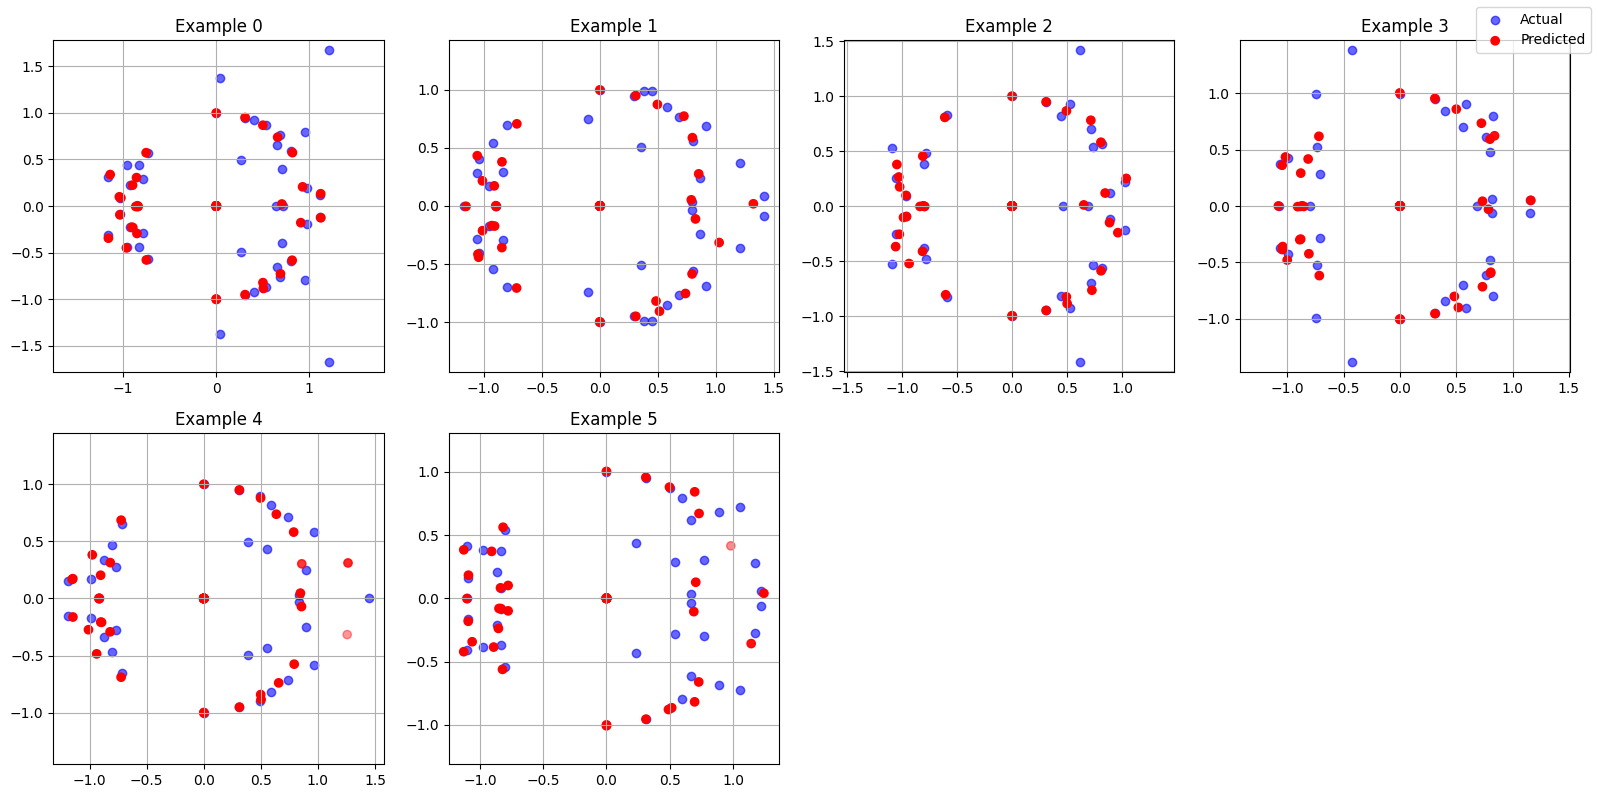

In [27]:
with torch.no_grad():
    model.eval()
    for x_tensor, x_mask, y_tensor in test_loader:
        x_tensor = x_tensor.to(device)
        x_mask = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=6)
        break
